Best Validation Balanced Accuracy: 0.0000

🧪 Test Set Performance (Multiclass)
Accuracy: 0.8170445660672401
Balanced Accuracy: 0.6902385316906091
              precision    recall  f1-score   support

           0     0.8362    0.9016    0.8677       640
           1     0.7967    0.7612    0.7785       448
           2     0.8026    0.6816    0.7372       179
           3     0.5556    0.4167    0.4762        12

    accuracy                         0.8170      1279
   macro avg     0.7478    0.6902    0.7149      1279
weighted avg     0.8151    0.8170    0.8145      1279



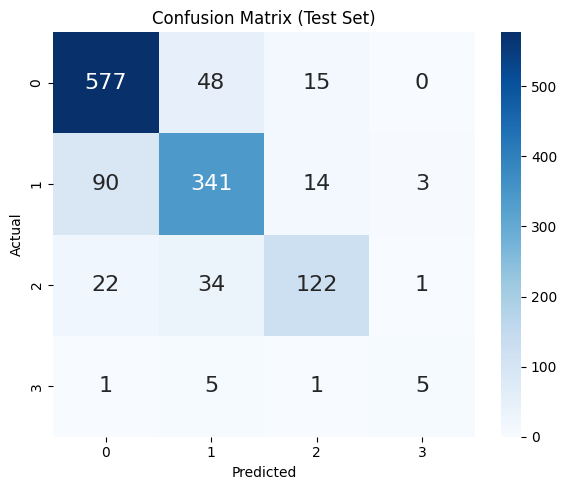

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier

# --- Load Datasets ---
df = pd.read_csv("train_features.csv")
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

core_features = df.drop(columns=["label", "label_name"], errors="ignore").columns.tolist()

# --- Extract Features and Labels ---
X_train = df[core_features]
y_train = df["label"]
X_val = val_df[core_features]
y_val = val_df["label"]
X_test = test_df[core_features]
y_test = test_df["label"]

# --- Manual Grid Search using Validation Set ---
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 12, 13],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

best_score = 0
best_params = {}

# Class ratio for scale_pos_weight (Impaired : No Impairment)
num_classes = len(np.unique(y_train))

# print("🔍 Hyperparameter tuning on validation set:")
# for max_depth, lr, n_est in product(param_grid['max_depth'],
#                                     param_grid['learning_rate'],
#                                     param_grid['n_estimators']):
#     model = XGBClassifier(
#         objective='multi:softprob',
#         eval_metric='mlogloss',
#         max_depth=max_depth,
#         learning_rate=lr,
#         n_estimators=n_est,
#         random_state=42,
#         verbosity=0
#     )
#     model.fit(X_train, y_train)
#     val_pred = model.predict(X_val)
#     val_score = balanced_accuracy_score(y_val, val_pred)
#     print(f"max_depth={max_depth}, lr={lr}, n_estimators={n_est} → Balanced Acc: {val_score:.4f}")
#     if val_score > best_score:
#         best_score = val_score
#         best_params = {
#             'max_depth': max_depth,
#             'learning_rate': lr,
#             'n_estimators': n_est
#         }
# 
# print("\n✅ Best Params from validation set:")
# print(best_params)
best_params = {
    'max_depth': 11,
    'learning_rate': 0.1,
    'n_estimators': 200
}
print(f"Best Validation Balanced Accuracy: {best_score:.4f}")

# --- Final Model with Early Stopping ---
clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=num_classes,
    random_state=42,
    early_stopping_rounds=100,

    **best_params
)


# Weight training samples inversely proportional to test set class frequencies
class_weights = y_test.value_counts(normalize=True).rdiv(1).to_dict()
sample_weights = y_train.map(class_weights)

clf.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=False
)



def evaluate_multiclass(model, X, y, dataset_name="Set"):
    y_pred = model.predict(X)
    print(f"\n🧪 {dataset_name} Performance (Multiclass)")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
    plt.title(f"Confusion Matrix ({dataset_name})")
    # increase size label x
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_xgb_4_{dataset_name.lower()}.png")
    plt.show()


evaluate_multiclass(clf, X_test, y_test, "Test Set")


# After Hypertuning
Best values found were:
- `n_estimators`: 200
- `max_depth`: 15
- `lr`: 1

In [ ]:
# --- Train Final Model on Combined Data ---
clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    **best_params
)
clf.fit(X_combined_scaled, y_combined)

# --- Evaluation Utility ---
label_map_binary = {0: "No Impairment", 1: "Impaired"}

def evaluate_binary(X, y, dataset_name="Set", threshold=0.5):
    probs = clf.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    print(f"\n🧪 {dataset_name} Performance (Binary, Threshold = {threshold})")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map_binary.values(), digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map_binary.values(),
                yticklabels=label_map_binary.values(),
                annot_kws={"size": 14})
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# --- Evaluate Final Model ---
evaluate_binary(X_test_scaled, y_test, "Test Set", threshold=0.45)

/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:58:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoostError: [02:58:13] /workspace/src/metric/elementwise_metric.cu:361: Check failed: preds.Size() == info.labels.Size() (6144 vs. 1536) : label and prediction size not match, hint: use merror or mlogloss for multi-class classification
Stack trace:
  [bt] (0) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2a6acc) [0x7a40db8a6acc]
  [bt] (1) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xd86ee3) [0x7a40dc386ee3]
  [bt] (2) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x6b1ea6) [0x7a40dbcb1ea6]
  [bt] (3) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x68ad80) [0x7a40dbc8ad80]
  [bt] (4) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterEvalOneIter+0x1d6) [0x7a40db7bf2f6]
  [bt] (5) /home/alof/anaconda3/envs/brainml/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6d8a) [0x7a4177386d8a]
  [bt] (6) /home/alof/anaconda3/envs/brainml/lib/python3.10/lib-dynload/../../libffi.so.8(+0x61cd) [0x7a41773861cd]
  [bt] (7) /home/alof/anaconda3/envs/brainml/lib/python3.10/lib-dynload/../../libffi.so.8(ffi_call+0xcd) [0x7a417738691d]
  [bt] (8) /home/alof/anaconda3/envs/brainml/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x931f) [0x7a417897831f]



/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:04:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Optimal threshold: 0.3941

🧪 Test Set (Adjusted Threshold) Performance (Threshold = 0.3700)
Accuracy: 0.8678655199374511
Balanced Accuracy: 0.8678684956964007
               precision    recall  f1-score   support

No Impairment     0.8709    0.8641    0.8675       640
     Impaired     0.8649    0.8717    0.8683       639

     accuracy                         0.8679      1279
    macro avg     0.8679    0.8679    0.8679      1279
 weighted avg     0.8679    0.8679    0.8679      1279



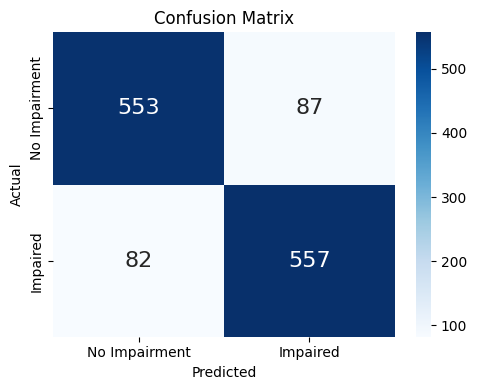

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier

# --- Load Datasets ---
df = pd.read_csv("train_features.csv")
test_df = pd.read_csv("test_features.csv")

# --- Re-label as binary: 0 = No Impairment, 1 = Any Impairment ---
df['label'] = df['label'].apply(lambda x: 0 if x == 0 else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 0 else 1)

# --- Extract Features ---
X = df.drop(columns=["label", "label_name"], errors="ignore")
y = df["label"]
X_test = test_df[X.columns]
y_test = test_df["label"]

# --- Scale Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# --- Hyperparameter Grid ---
param_grid = {
    'max_depth': [7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400]
}

best_score = 0
best_params = {}

# Class ratio for scale_pos_weight (Impaired : No Impairment)
scale_pos_weight = sum(y == 0) / sum(y == 1)

# --- Cross-Validation Search ---
# print("🔍 Cross-validation search:")
# for max_depth, lr, n_est in product(param_grid['max_depth'],
#                                     param_grid['learning_rate'],
#                                     param_grid['n_estimators']):
#     model = XGBClassifier(
#         objective='binary:logistic',
#         use_label_encoder=False,
#         eval_metric='logloss',
#         scale_pos_weight=scale_pos_weight,
#         max_depth=max_depth,
#         learning_rate=lr,
#         n_estimators=n_est,
#         random_state=42,
#         verbosity=0
#     )
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='balanced_accuracy')
#     mean_score = np.mean(scores)
#     print(f"max_depth={max_depth}, lr={lr}, n_estimators={n_est} → Mean Balanced Acc: {mean_score:.4f}")
#     
#     if mean_score > best_score:
#         best_score = mean_score
#         best_params = {
#             'max_depth': max_depth,
#             'learning_rate': lr,
#             'n_estimators': n_est
#         }
# 
# print("\n✅ Best Params from CV:")
# print(best_params)
# print(f"Best CV Balanced Accuracy: {best_score:.4f}")

best_params = {
    'max_depth': 9,
    'learning_rate': 0.2,
    'n_estimators': 200
}

# --- Train Final Model ---
clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    **best_params
)
clf.fit(X_scaled, y)

# --- Evaluation Utility ---
label_map_binary = {0: "No Impairment", 1: "Impaired"}

def evaluate_binary(X, y, dataset_name="Set", threshold=0.5):
    probs = clf.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    print(f"\n🧪 {dataset_name} Performance (Threshold = {threshold:.4f})")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map_binary.values(), digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map_binary.values(),
                yticklabels=label_map_binary.values(),
                annot_kws={"size": 1})
    plt.title(f"Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_xgb_binary_{dataset_name.lower()}.png")
    plt.show()

def find_best_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx]

# --- Evaluate on Test Set ---
best_thresh = find_best_threshold(y_test, clf.predict_proba(X_test_scaled)[:, 1])
print(f"\nOptimal threshold: {best_thresh:.4f}")
evaluate_binary(X_test_scaled, y_test, "Test Set (Adjusted Threshold)", threshold=0.37)
